# Week 2: Principal Component Analysis


In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and/or in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 


## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

  a. [Examining the Basis Vectors and Scores](#basis)

  b. [Selecting the Number of Components](#nocomponents)

  c. [Other Digits](#other)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',parser = 'auto')
X = mnist.data
y = mnist.target

### 🚩 Exercise 1 (CORE)

What is stored in `X` and `y` in the command above? What is the shape/datatype etc if an array?


In [5]:
print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB
None


In [6]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


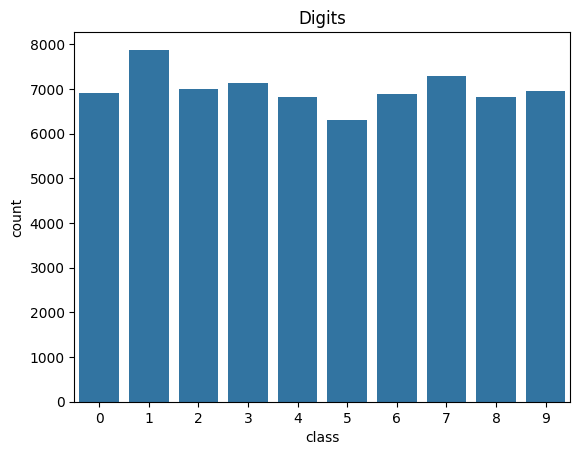

In [7]:
sns.countplot(x = y)
plt.title("Digits")
plt.show()

The images are contained in `X`. There are 70,000 images with a total 784 pixels (28 by 28). 

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [8]:
digits_dict = {}
X_= X.values
count = 0

for label in y:
  if label in digits_dict:
    digits_dict[label] += [X_[count]]
  else:
    digits_dict[label] = [X_[count]]
  count += 1

Next let's visualize some of the images. We will start by picking a label and plotting a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and we will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`. Try also changing the label to view different digits.

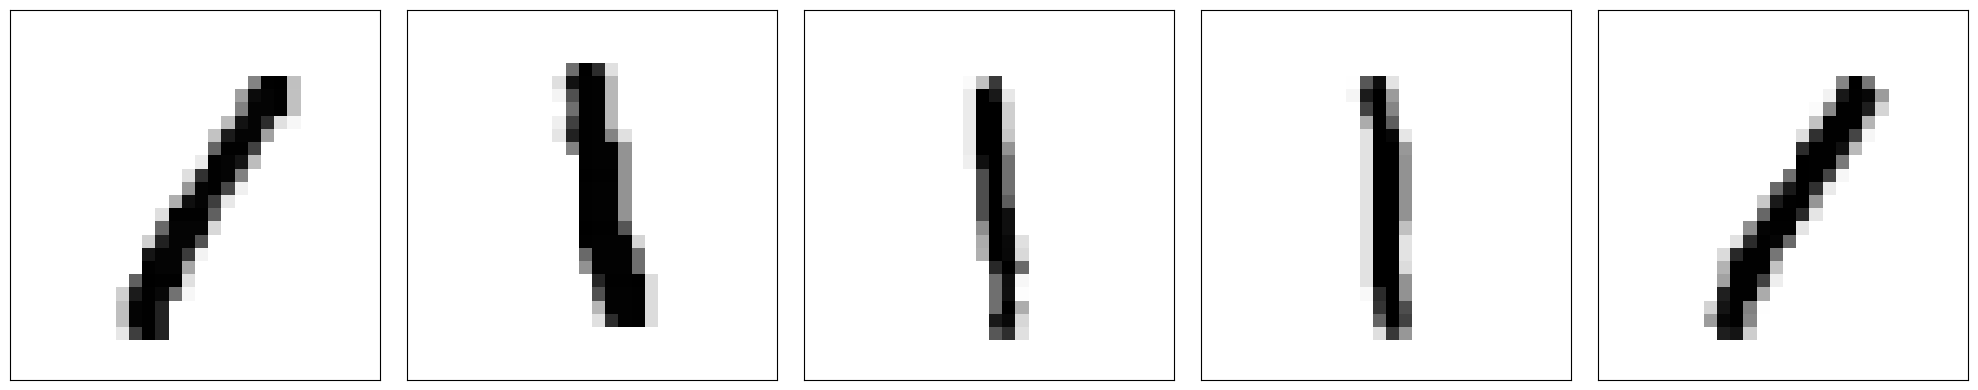

In [9]:
mylabel = '1'
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4))
for j in range(n_images_per_label):
    ax_number = 1 + j
    ax = fig.add_subplot(1, n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabel][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 2 (EXTRA)

Edit the code above to plot a few images for multiple labels.

<br>
<details><summary><b><u>Hint</b></u></summary>

Create a vector of labels and add additional for loop in the code above.
</details>

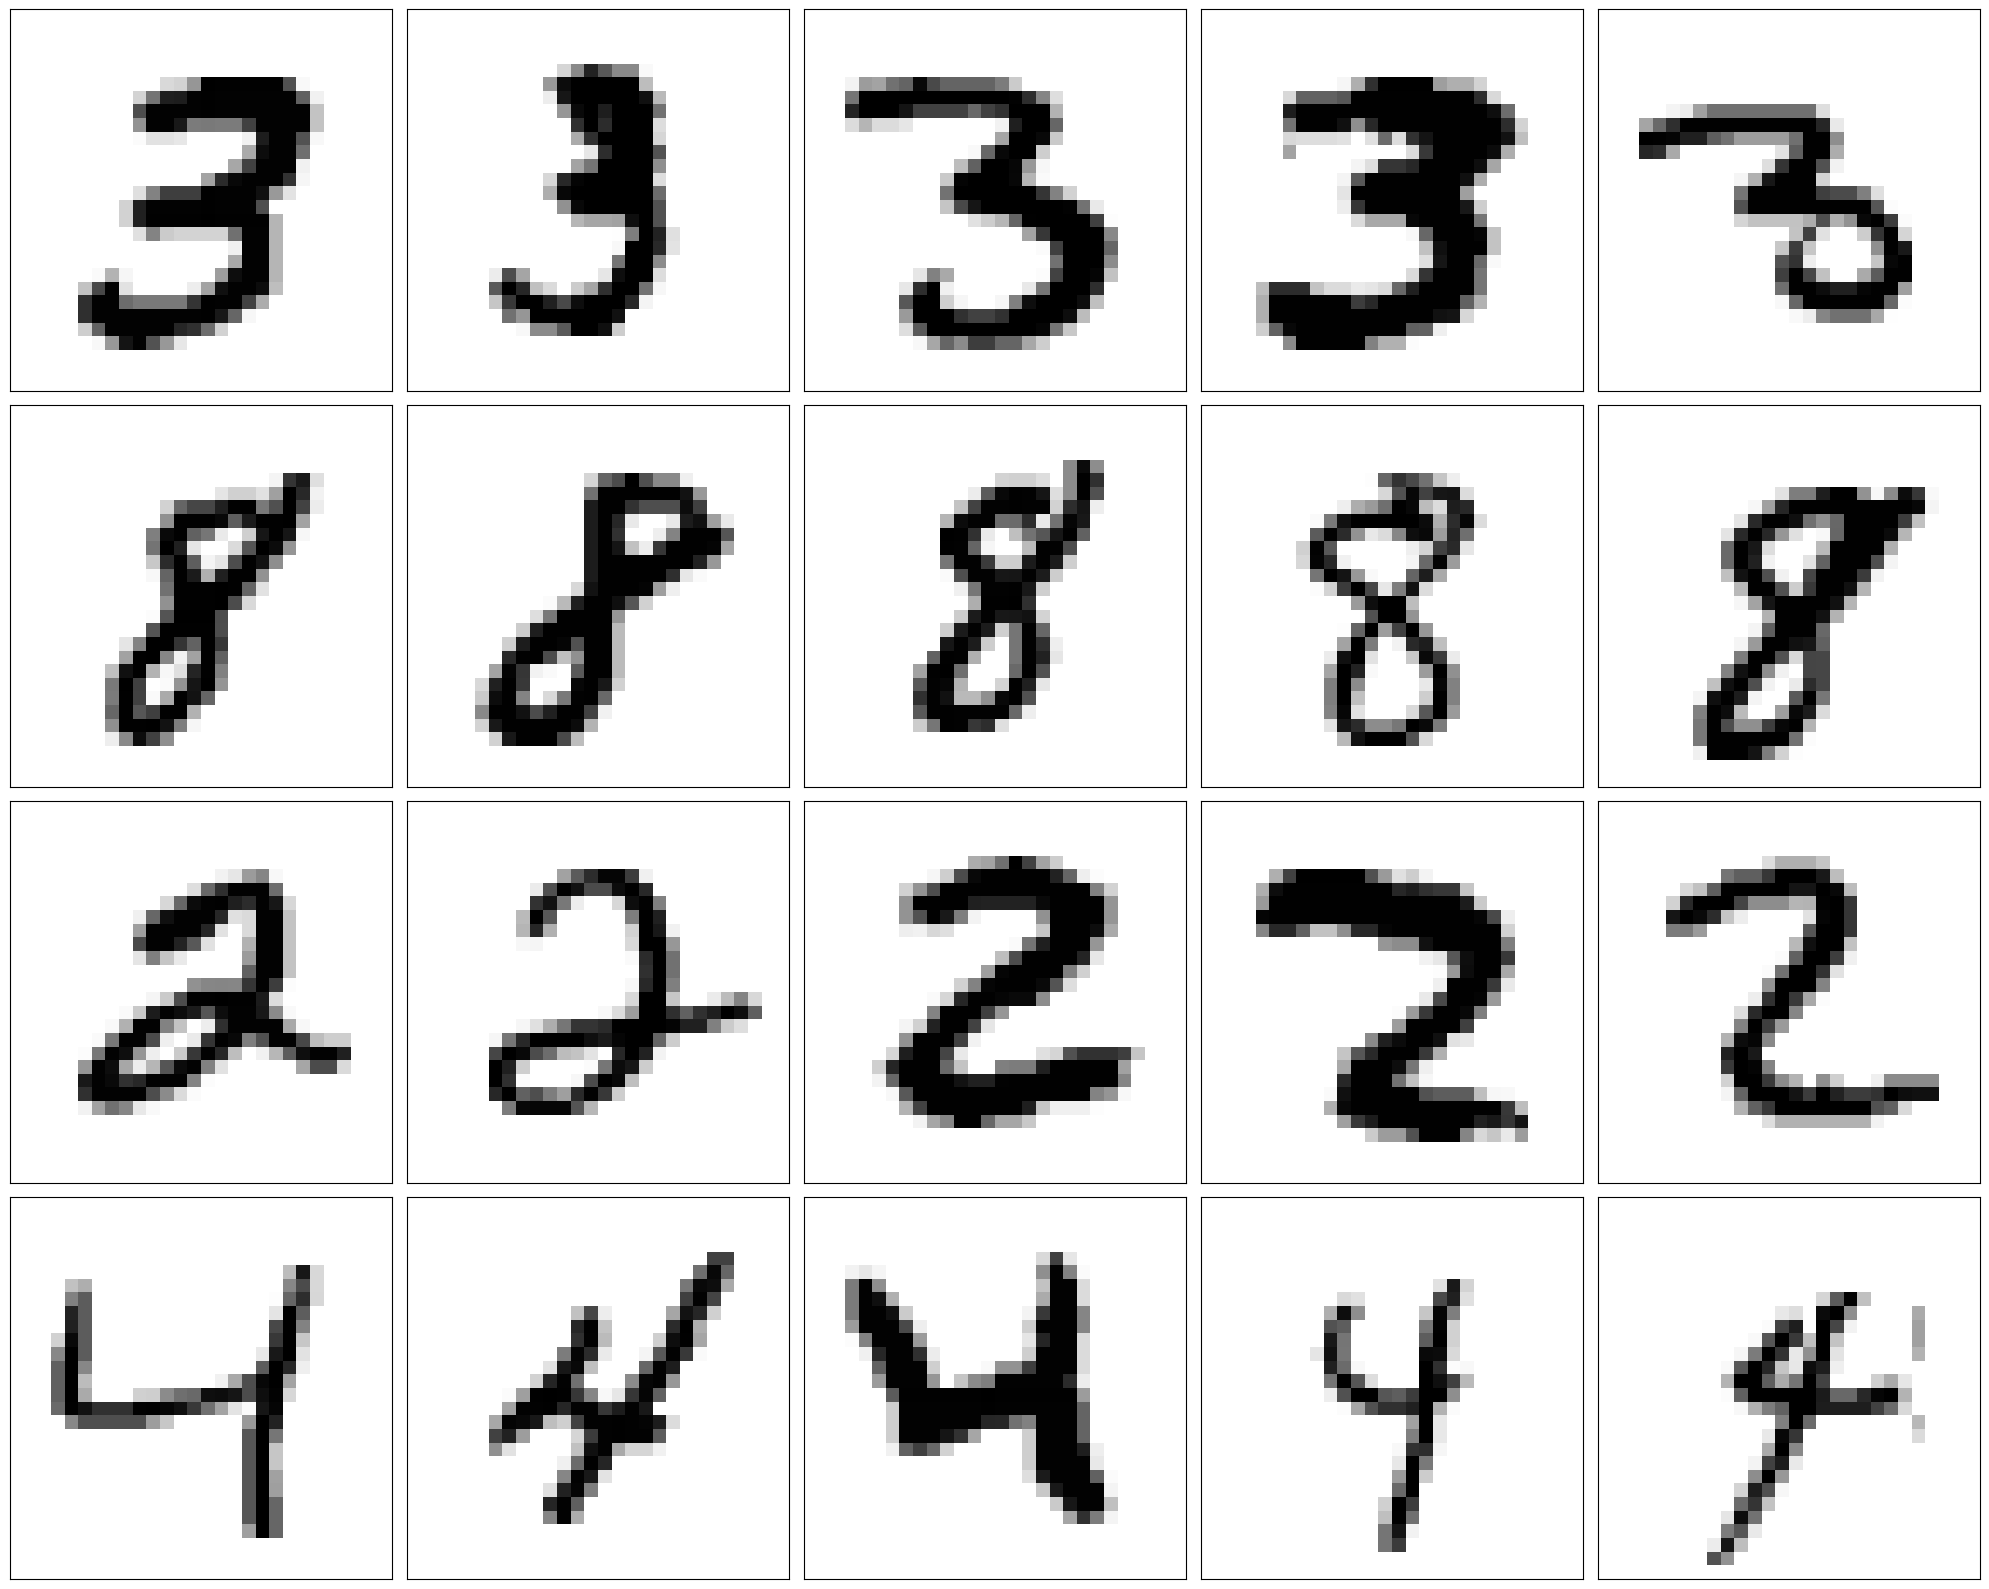

In [10]:
mylabels = ['3', '8', '2','4']
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4*len(mylabels)))
for i in range(len(mylabels)):
  for j in range(n_images_per_label):
    ax_number = i * n_images_per_label + 1 + j
    ax = fig.add_subplot(len(mylabels), n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabels[i]][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes`. Define also `N` (# datapoints) and `D` (# features).

What are the features in this problem? How many features and data points are there? 

In [11]:
X_threes = np.asarray(digits_dict['3'])
N, D = X_threes.shape
print('There are', N, 'data points and', D, 'features')


There are 7141 data points and 784 features


The features are the pixels of the image.

### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

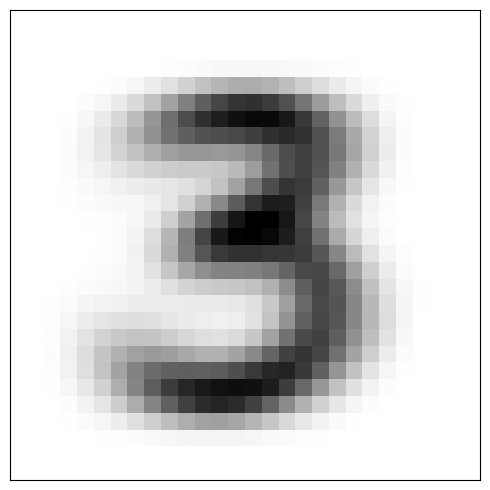

In [12]:
X_three_mean = np.mean(X_threes, axis=0, keepdims=True)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(X_three_mean.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

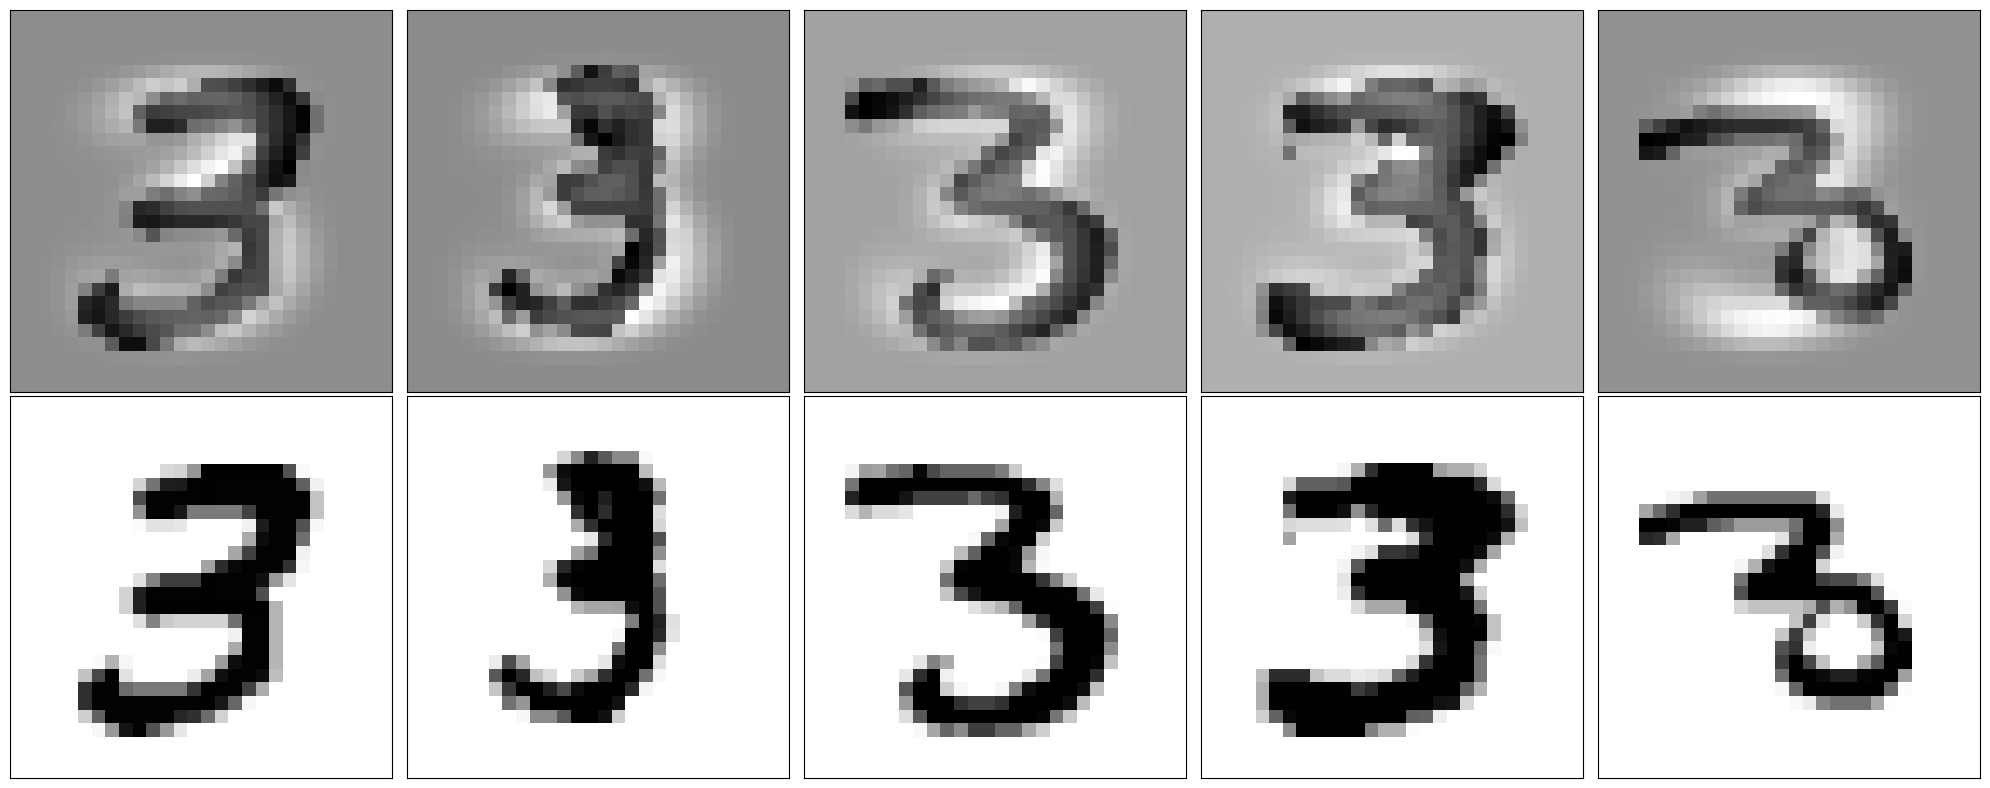

In [13]:
X_three_centred = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_centred[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(X_threes[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

We know from lectures, that if the features have very different scales, then the principal components can be dominated by the features with high variance. However, for imaging data, the pixels are measured in the same units. Thus, no scaling is required but the features do need to be centered. Ideed, there are some pixels (e.g. at the edges of the image) with very little variation, and we want them to have less influence on the principal components compared with the more important pixels towards the center; by not scaling the features, this is incorporated. 

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transform from the `sklearn.decomposition` package:

- We can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). After fitting, we can access the mean through the attribute `mean_`. If we also want to standardize to have not only zero mean but also unit variance, we can set `whiten=True`.

- We can access the basis vectors (principal components) through the `components_` attribute.

- We can call `fit()` to fit the model, followed by `transform` to obtain the low-dimensional representation (or also `fit_transform`). 

 First, let's create the PCA transform and call `fit()`:

In [14]:
pca_threes = PCA(n_components = 200)
pca_threes.fit(X_threes)


PCA(n_components=200)

## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (EXTRA)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

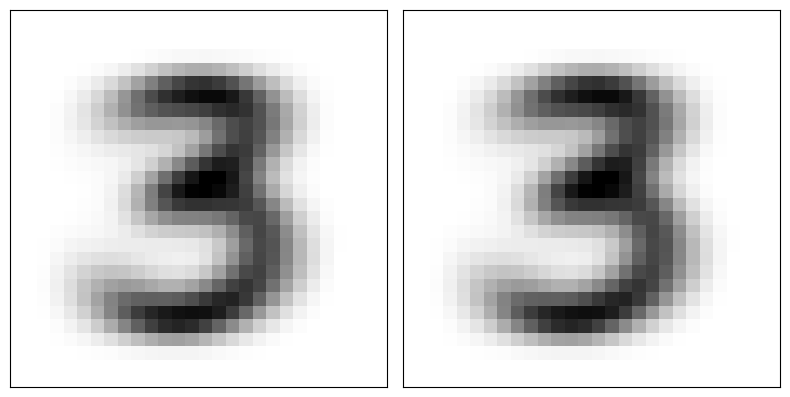

In [15]:
fig, ax = plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(pca_threes.mean_.reshape(28, 28), cmap='gray_r')
ax[1].imshow(X_three_mean.reshape(28, 28), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 7 (CORE)

Plot the the first ten basis vectors as images by accessing the `components_` attribute. Overall, what patterns do they seem describe? 

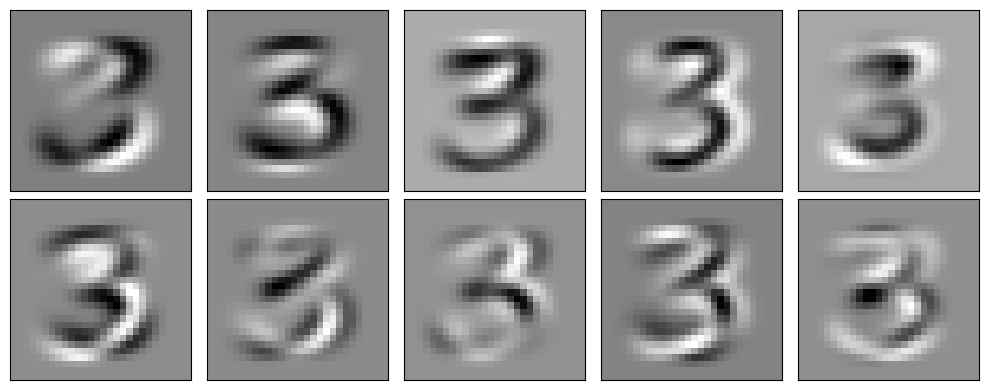

In [16]:
import math
n_plot = 10

fig, ax = plt.subplots(2,5,figsize=(10,4))
for n in range(n_plot):
  ax[math.floor(n/5), n - 5*math.floor(n/4)].imshow(pca_threes.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The basis vectors seem to mostly describe differences in orientation and style of the images. In general, it becomes more difficult to describe the patterns when we examine the latter basis vectors. We will look at later visualizations to better understand the patterns represented by each basis vector.

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the PCA scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

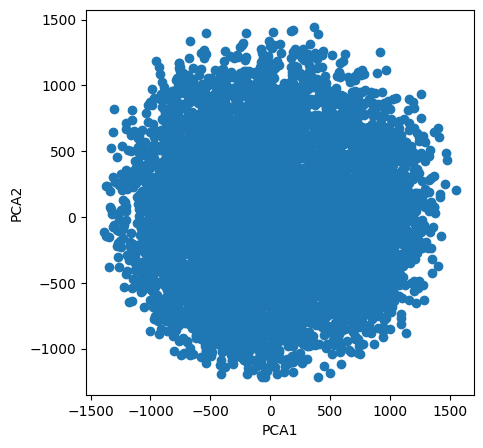

In [17]:
scores = pca_threes.transform(X_threes)

i, j = 0, 1 #component indicies 
fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.scatter(scores[:,i], scores[:,j])
ax.set_xlabel('PCA%d' % (i+1))
ax.set_ylabel('PCA%d' % (j+1))
plt.show()

To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [18]:
s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,1],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,1] - s2q[j])**2).reshape(N,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]

idx = idx.astype(int)

b) Now, add these points in red to your plot above in.

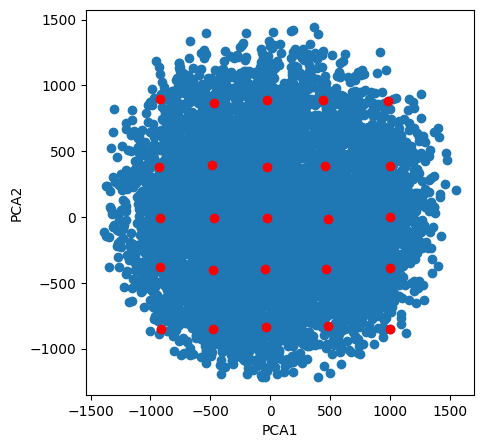

In [19]:
i, j = 0, 1 #component indicies 
fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.scatter(scores[:,i], scores[:,j])
ax.scatter(scores[idx.reshape(-1),i], scores[idx.reshape(-1),j],c = 'r')
ax.set_xlabel('PCA%d' % (i+1))
ax.set_ylabel('PCA%d' % (j+1))
plt.show()

c) Run the following code to plot the images corresponding to this grid of points. Describe the general pattern of the first (left to right) and second (down to up) principal component.

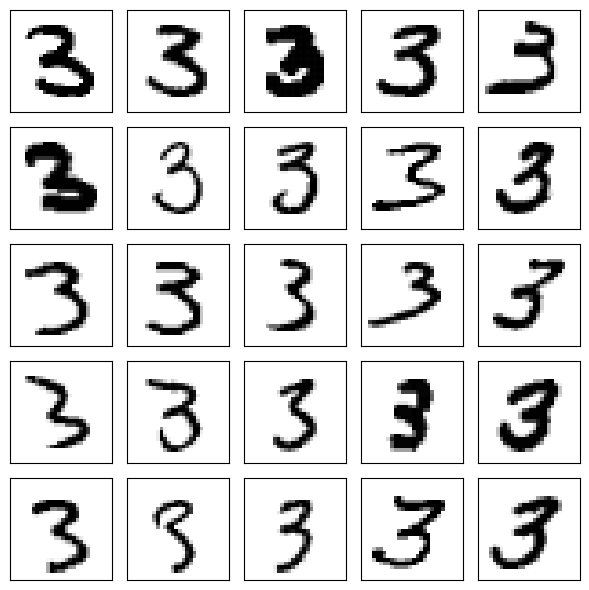

In [20]:
fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[idx[i,j],:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

As we move from left to right along the first principal component, we see that its seems to capture the orientation of the digit. As we move up along the second principal component, we see that it seems to capture line thickness.

You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

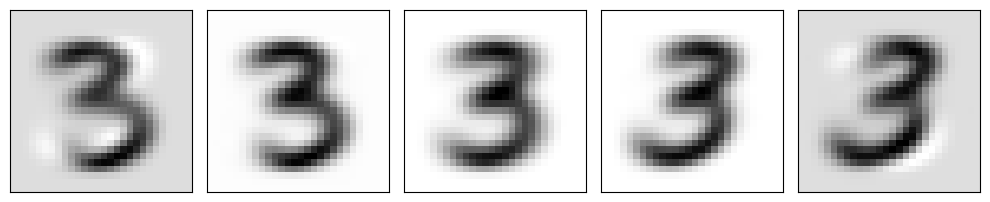

In [21]:
weight1 = [-1000,-500,0,500,1000]
weight2 = 0

images_pc1 = np.zeros([len(weight1),D])

count = 0
for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. Look at the histogram of its scores to decide what values of weights to use. 

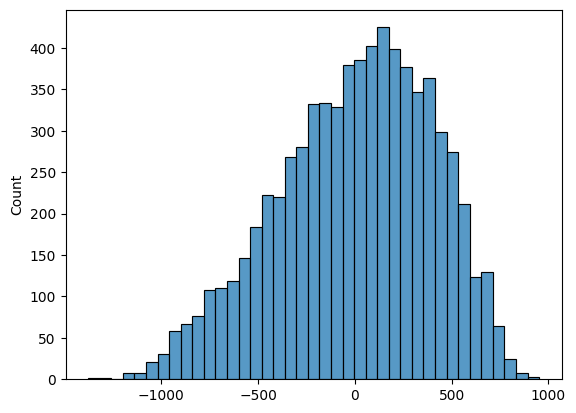

In [22]:
# First, look at distribution of the third principal component
import seaborn as sns

sns.histplot(scores[:,3])
plt.show()

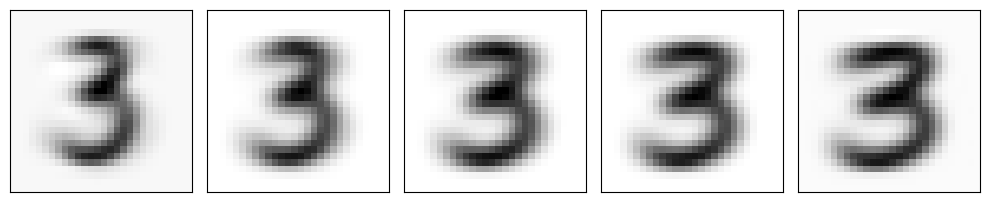

In [23]:
# Take weight values based on the distribution of the scores
weight3 = [-700,-300,0,300,700]
weight2 = 0
weight1 = 0

images_pc3 = np.zeros([len(weight3),D])

count = 0
for w in weight3:   
    images_pc3[count,:] =(pca_threes.mean_ + pca_threes.components_[2,:]*w + 
                          pca_threes.components_[0,:]*weight1 + pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight3),figsize=(10,6))
for i in range(len(weight3)):
    ax[i].imshow(images_pc3[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The third principal component seems to describe the width of the images. 

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

In [24]:
from scipy.linalg import svd
U, Dmat, V_T = svd(X_three_centred, full_matrices=True) 

print(U.shape, Dmat.shape, V_T.shape)

(7141, 7141) (784,) (784, 784)


Setting `full_matrices=False` would produce the "economy SVD" where only the first $D$ columns of the left singular vectors are returned. 

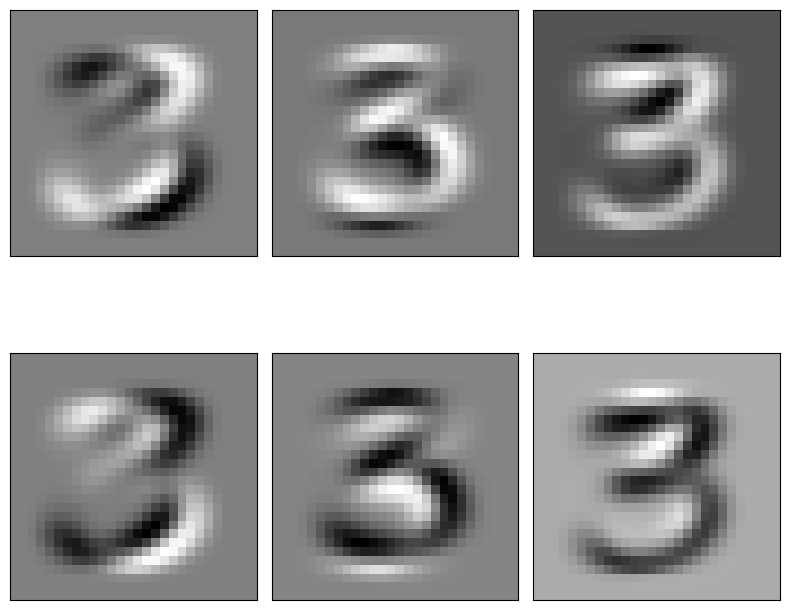

In [25]:
n_plot = 3

fig, ax = plt.subplots(2,3,figsize=(8, 8))
for n in range(n_plot):
  ax[0,n].imshow(V_T[n,:].reshape((28,28)), cmap='gray_r')
  ax[1,n].imshow(pca_threes.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Also, `PCA()` uses an SVD decompostion. Different SVD solvers are available and the default is selected based on the size of the data matrix and number of components. 

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much variance is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

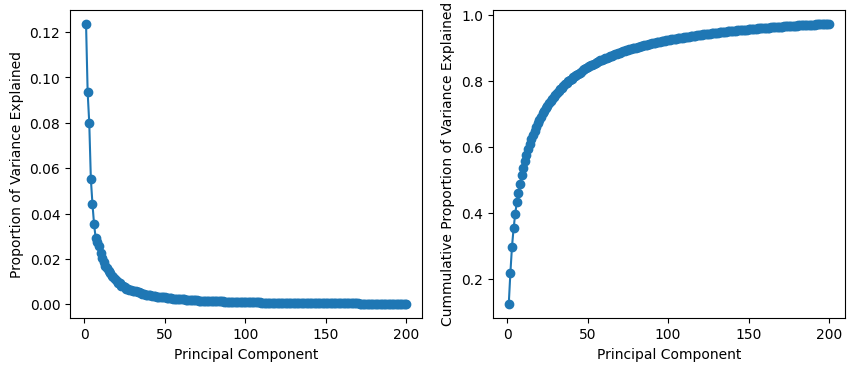

In [26]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(pca_threes.n_components_)+1
ax[0].plot(ticks, pca_threes.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, pca_threes.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

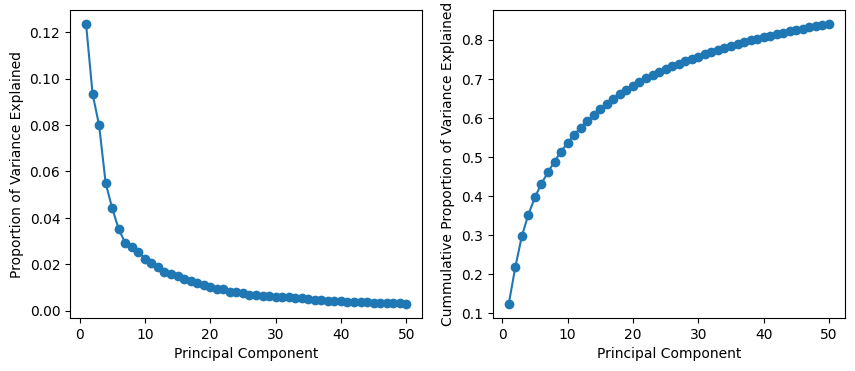

In [27]:
# Zoom in on the first 50
n_c_max = 50
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(n_c_max)+1
ax[0].plot(ticks, pca_threes.explained_variance_ratio_[range(n_c_max)], marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, pca_threes.explained_variance_ratio_[range(n_c_max)].cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

There appears to be an elbow around 7 components, after that the proportion of variance explained by each component drops off. If we use 7 components, we explain about $46\%$ of the variance. Because of the high correlation of the pixels, we can explain a large amount of the variance with $L<<D$ components.  

Note your answer can vary here and will very much depend on the problem at hand. If for example you are using PCA for feature engineering, you may be interested in a large number of components that together explain a specified amount of the variance (e.g. $80\%$).  

In [28]:
sum(pca_threes.explained_variance_ratio_[range(7)])

np.float64(0.4605188164917008)

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

In [1]:
pca_threes_n7 = PCA(n_components=7).fit(X_threes)

scores_n7 = pca_threes_n7.transform(X_threes)
X_r = pca_threes_n7.inverse_transform(scores_n7)

n_images = 5

fig, ax = plt.subplots(2, n_images, figsize=(12, 6))

for n in range(n_images):
    # Original images
    ax[0, n].imshow(X_threes[n, :].reshape((28, 28)), cmap='gray_r')
    ax[0, n].set_title('Original')

    # Reconstructed images
    ax[1, n].imshow(X_r[n, :].reshape((28, 28)), cmap='gray_r')
    ax[1, n].set_title('Reconstructed')

plt.setp(ax, xticks=[], yticks=[])

fig.tight_layout()
plt.show()


NameError: name 'PCA' is not defined

With only 7 components, it is able to capture well the main characteristics of image. The reconstruction of some images is not as good, for example the last image, with a more unique style. 

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digit. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

In [30]:
# Extract data and fit PCA
X_sevens = np.asarray(digits_dict['7'])
N, D = X_sevens.shape

pca_sevens = PCA(n_components = 50)
pca_sevens.fit(X_sevens)

PCA(n_components=50)

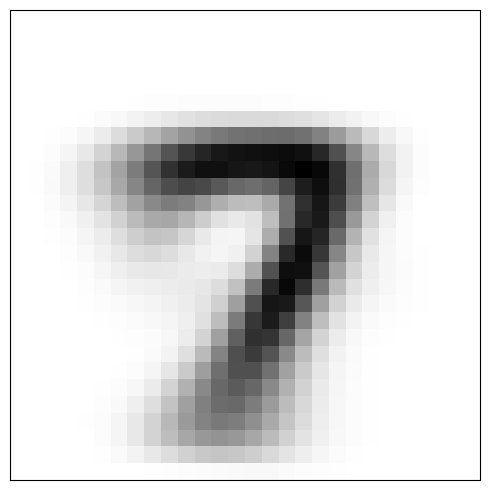

In [31]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_sevens.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

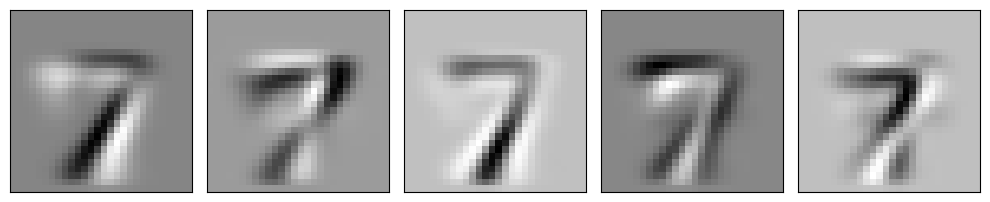

In [32]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_sevens.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The first component seems to describe orientation, while the second seems to describe a different style.

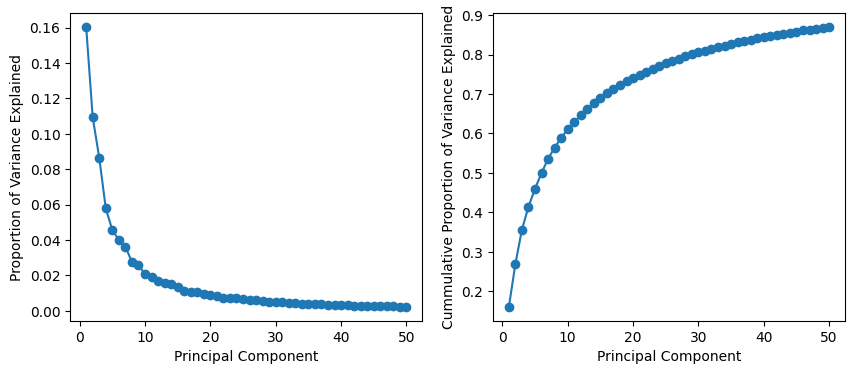

In [33]:
# Scree plot of PVE
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(pca_sevens.n_components_)+1
ax[0].plot(ticks, pca_sevens.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, pca_sevens.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

In [34]:
print(sum(pca_sevens.explained_variance_ratio_[range(8)]))
print(sum(pca_sevens.explained_variance_ratio_[range(7)]))

0.5638239542554224
0.5361464055122018


There seems to be an elbow around 8 (or 10) components, which explains approximately $56\%$ of the variance. The PVE seems to be slightly higher than for three. In general, we may anticipate less components for a digit in which we might expect less variation.

### Exercise 14 (EXTRA)

Finally, consider now two digits of your choice (edit the code below if you wish to pick different digits).


In [35]:
# Extract data 
X_twodigits = np.concatenate((digits_dict['3'], digits_dict['8']))
N, D = X_twodigits.shape

Run the following code to compute and plot the mean and some of the principle components for this dataset. 

In [36]:
# Fit PCA
pca_digits = PCA(n_components = 50)
pca_digits.fit(X_twodigits)

PCA(n_components=50)

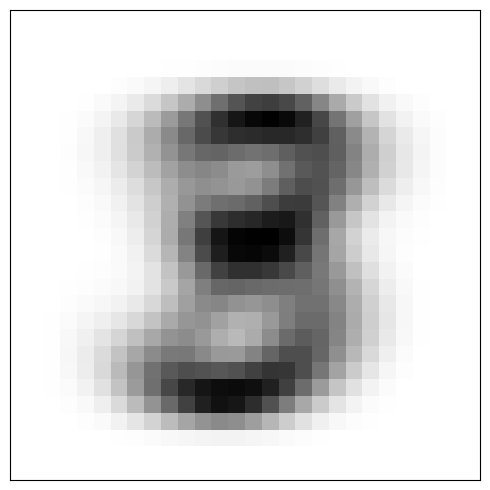

In [37]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_digits.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

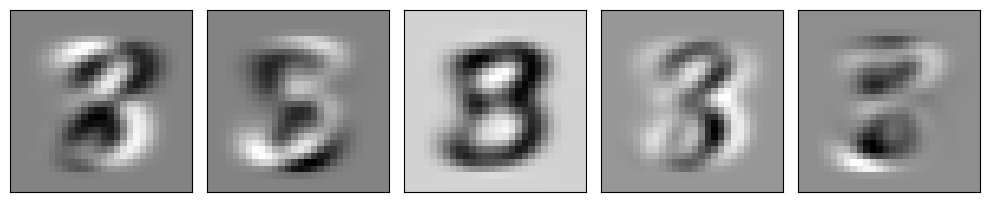

In [38]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_digits.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?

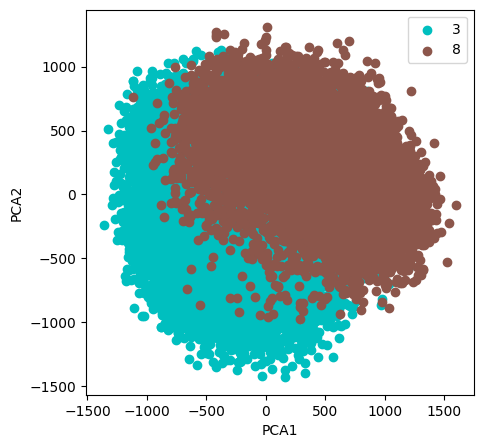

In [39]:
# Plot scores and color by label

scores = pca_digits.transform(X_twodigits)
y_twodigits = np.concatenate((3*np.ones((len(digits_dict['3']),1)), 8*np.ones((len(digits_dict['8']),1)))).reshape(-1)
yu =  [3,8]
colors = ['b','g','r','c','m','y','k','tab:orange','tab:brown','tab:pink']

i, j = 0, 1 #component indicies 
fig, ax = plt.subplots(1,1,figsize=(5, 5))
for dig in yu:
    ax.scatter(scores[y_twodigits==dig,i], scores[y_twodigits==dig,j], c = colors[dig],label=dig)
ax.legend()
ax.set_xlabel('PCA%d' % (i+1))
ax.set_ylabel('PCA%d' % (j+1))
plt.show()

Notice that the digits tend to cluster together. The 3s tend to have smaller values along PC 1 and PC 2, while the 8s have larger values. 

We can also generate artificial images and observe how image gradually change from 3s to 8s as move along the PCs. 

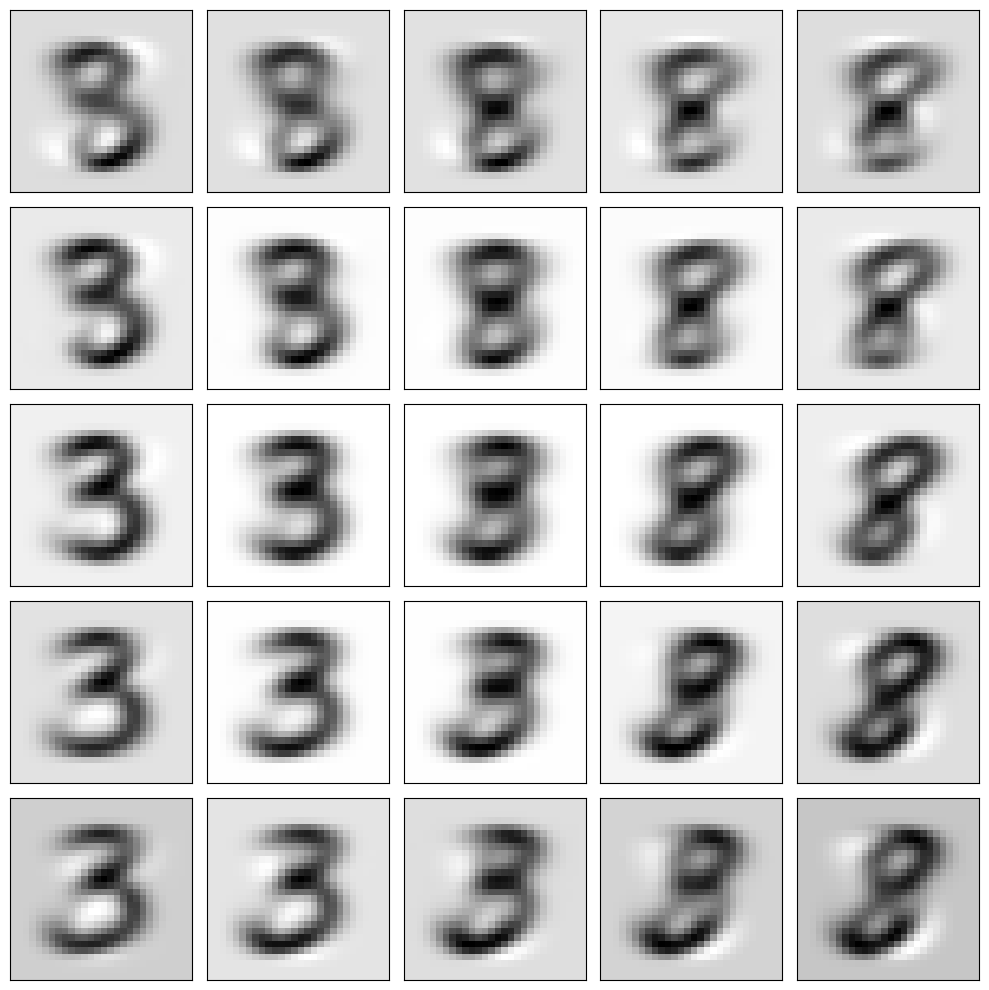

In [40]:
weight1 = [-800,-400,0,400,800]
weight2 = [-800,-400,0,400,800]

images_pc12 = np.zeros([len(weight1)*len(weight2),D])

count = 0
for w1 in weight1:
    for w2 in weight2:     
        images_pc12[count,:] =(pca_digits.mean_ + pca_digits.components_[0,:]*w1+pca_digits.components_[1,:]*w2)
        count += 1
    

fig, ax = plt.subplots(len(weight1),len(weight2),figsize=(10,10))
for i in range(len(weight1)):
    for j in range(len(weight2)):
        n = i * len(weight2) +  j
        ax[len(weight2)-1-j,i].imshow(images_pc12[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [41]:
!jupyter nbconvert --to pdf mlp_week02_key.ipynb 

[NbConvertApp] Converting notebook mlp_week02_key.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'mlp_week02_key.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexpo

# Week 2: Principal Component Analysis


In this workshop, we will work through a set of problems on dimensionality reduction -- a cannonical form of unsupervised learning. Within the machine learning pipeline, dimensionality reduction is an important tool, which can used in EDA to understand patterns in the data, feature engineering to create a low-dimensional representation of the inputs, and/or in the final phase when you are presenting and visualizing your solution.

As usual, the worksheets will be completed in teams of 2-3, using **pair programming**, and we have provided cues to switch roles between driver and navigator. When completing worksheets:

>- You will have tasks tagged by (CORE) and (EXTRA). 
>- Your primary aim is to complete the (CORE) components during the WS session, afterwards you can try to complete the (EXTRA) tasks for your self-learning process. 
>- Look for the 🏁 as cue to switch roles between driver and navigator.
>- In some Exercises, you will see some beneficial hints at the bottom of questions.

Instructions for submitting your workshops can be found at the end of worksheet. As a reminder, you must submit a pdf of your notebook on Learn by 16:00 PM on the Friday of the week the workshop was given. 

As you work through the problems it will help to refer to your lecture notes (navigator). The exercises here are designed to reinforce the topics covered this week. Please discuss with the tutors if you get stuck, even early on! 


## Outline

1. [Problem Definition and Setup](#setup)

2. [Principal Component Analysis](#pca)

  a. [Examining the Basis Vectors and Scores](#basis)

  b. [Selecting the Number of Components](#nocomponents)

  c. [Other Digits](#other)

# Problem Definition and Setup <a id='setup'></a>

## Packages

First, lets load in some packages to get us started. 

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

## Data

Our dataset will be the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digits, which we will download from sklearn. The dataset consists of a set of greyscale images of the numbers 0-9 and corresponding labels. Usually the goal is to train a classifier (i.e. given an image, what digit does it correspond to?). Here we will throw away the labels and focus on the images themselves. Specifically, we will use dimensionality reduction to explore the images and underlying patterns and find a low-dimensional representation.

First, load the data:

In [43]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',parser = 'auto')
X = mnist.data
y = mnist.target

### 🚩 Exercise 1 (CORE)

What is stored in `X` and `y` in the command above? What is the shape/datatype etc if an array?


In [44]:
print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: int64(784)
memory usage: 418.7 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB
None


In [45]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


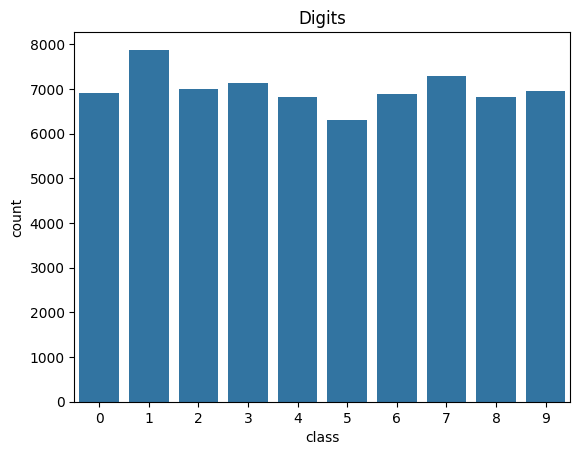

In [46]:
sns.countplot(x = y)
plt.title("Digits")
plt.show()

The images are contained in `X`. There are 70,000 images with a total 784 pixels (28 by 28). 

Now, let's create a dictionary, with the digit classes (0-9) as keys, where the correponding values are the set of all images corresponding to that particular label. 

In [47]:
digits_dict = {}
X_= X.values
count = 0

for label in y:
  if label in digits_dict:
    digits_dict[label] += [X_[count]]
  else:
    digits_dict[label] = [X_[count]]
  count += 1

Next let's visualize some of the images. We will start by picking a label and plotting a few images from within the dictionary. Note that each image contains a total of 784 pixels (28 by 28) and we will need to `reshape` the image to plot with `imshow(...,cmap='gray_r')`. Try also changing the label to view different digits.

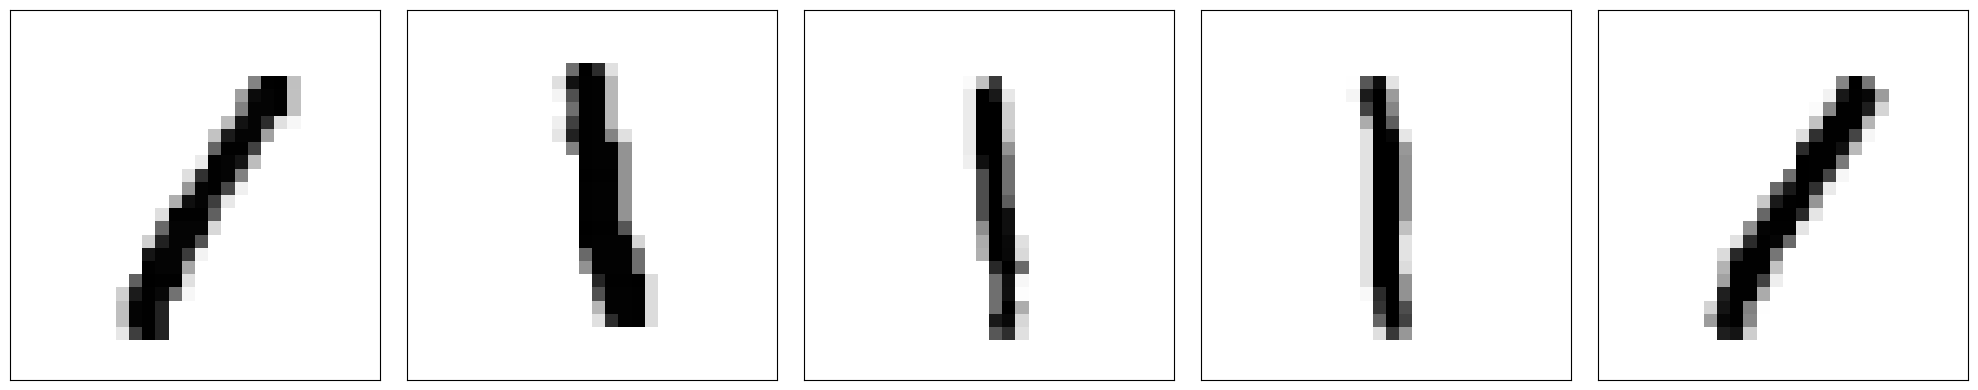

In [48]:
mylabel = '1'
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4))
for j in range(n_images_per_label):
    ax_number = 1 + j
    ax = fig.add_subplot(1, n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabel][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 2 (EXTRA)

Edit the code above to plot a few images for multiple labels.

<br>
<details><summary><b><u>Hint</b></u></summary>

Create a vector of labels and add additional for loop in the code above.
</details>

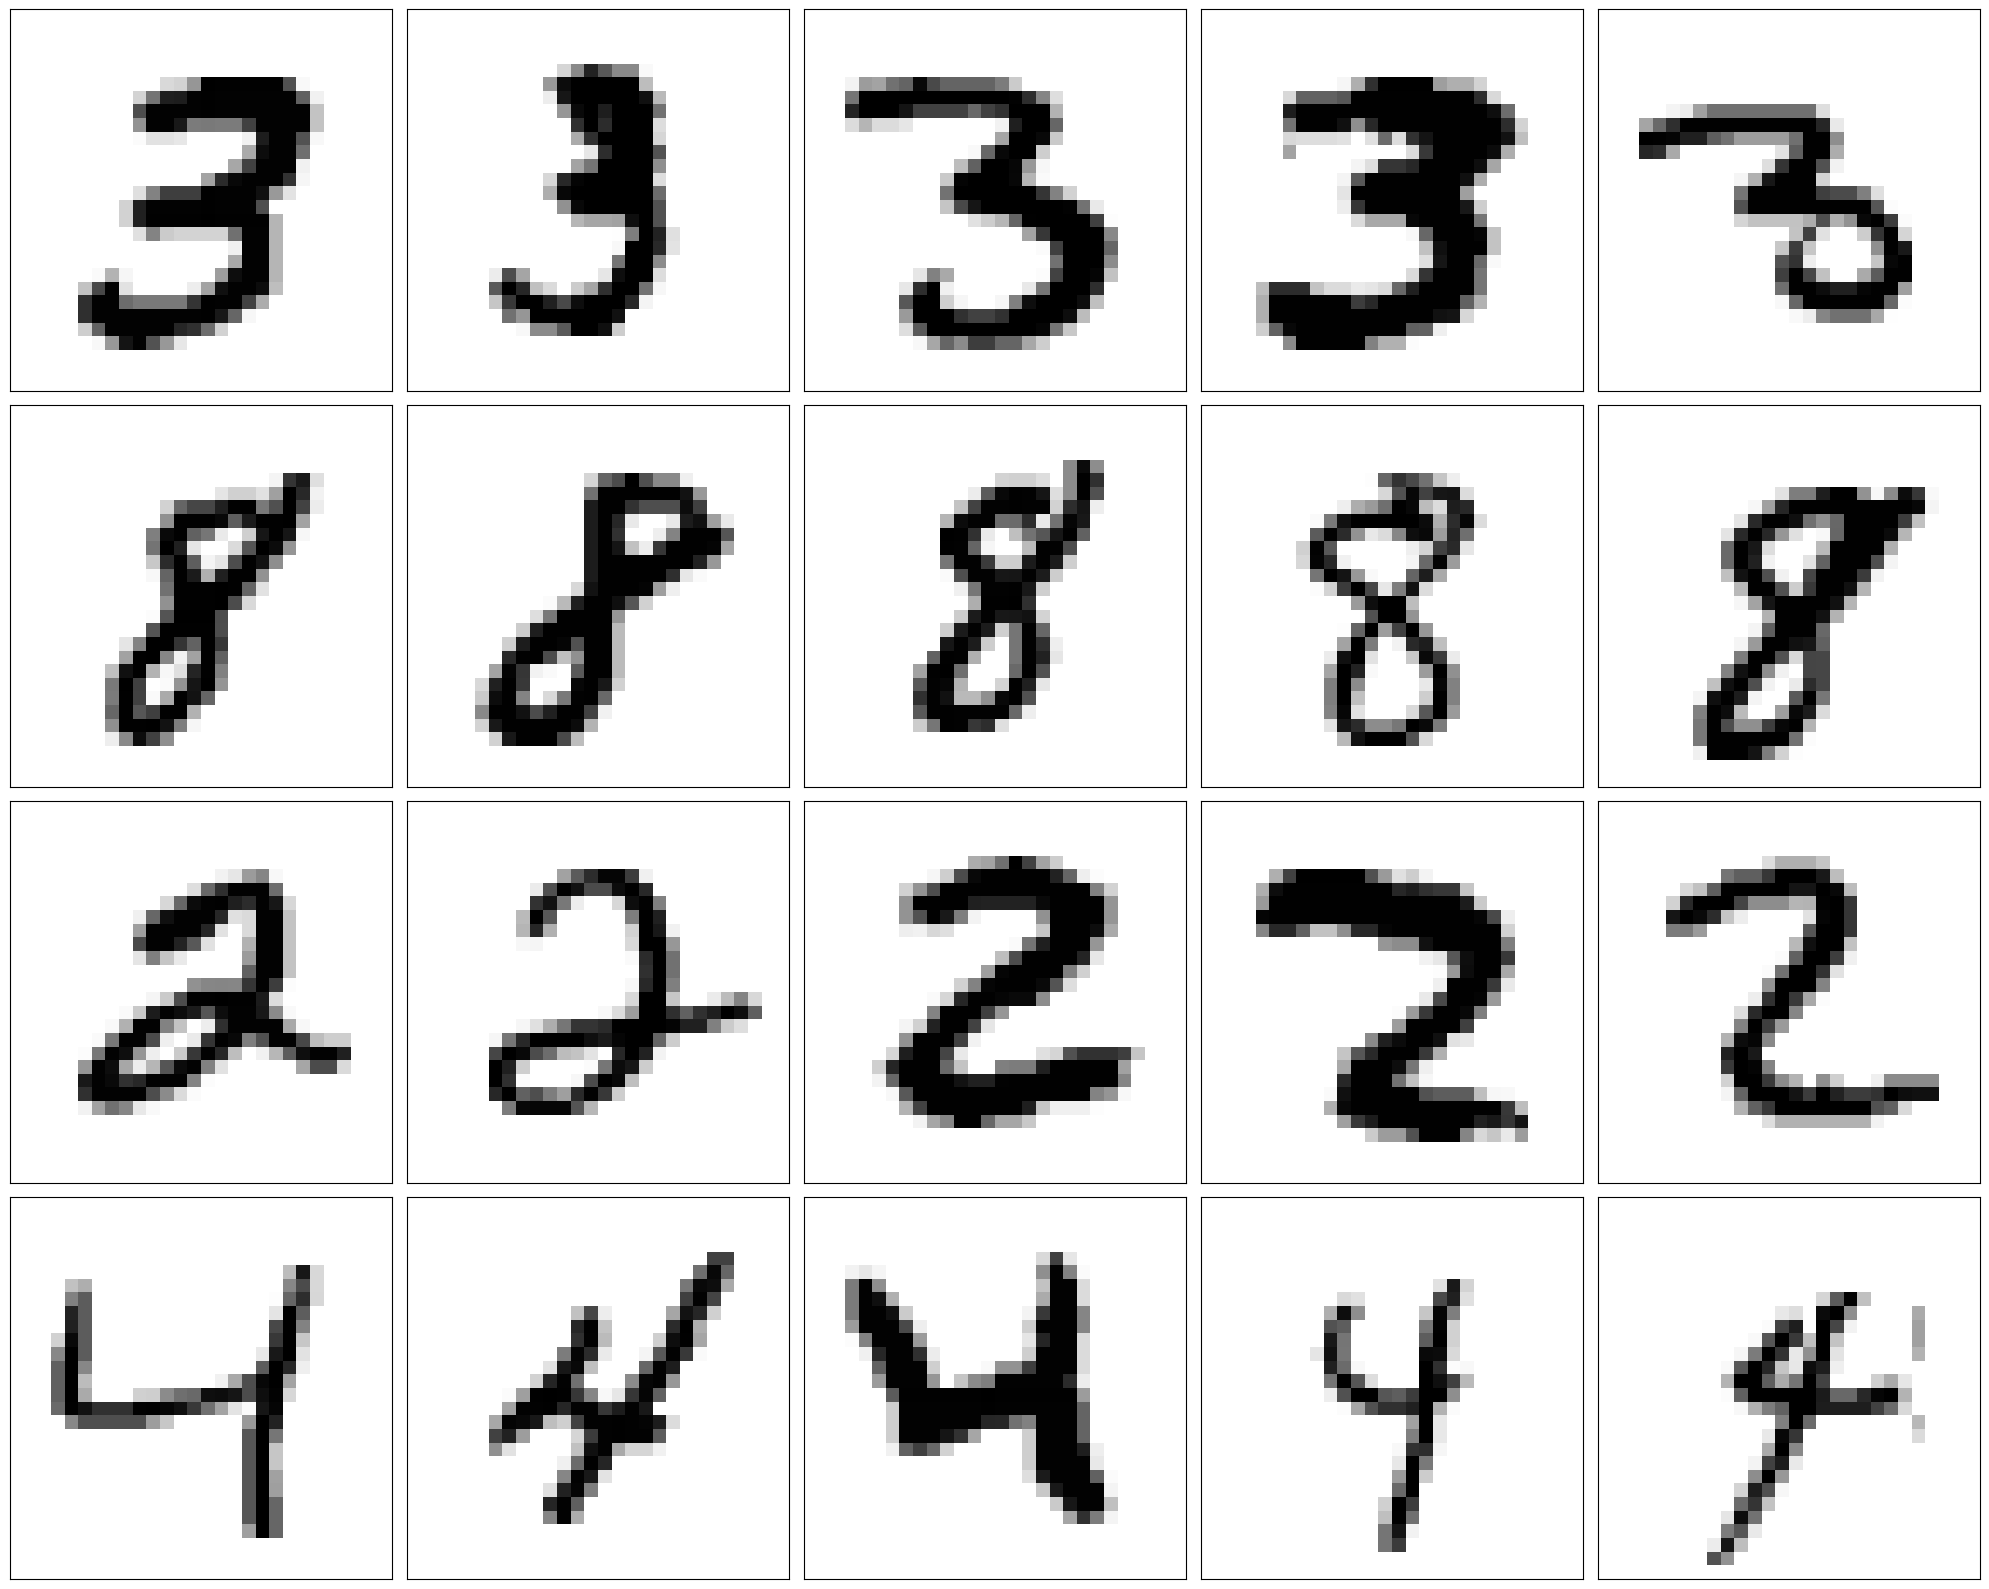

In [49]:
mylabels = ['3', '8', '2','4']
n_images_per_label = 5

fig = plt.figure(figsize=(4*n_images_per_label, 4*len(mylabels)))
for i in range(len(mylabels)):
  for j in range(n_images_per_label):
    ax_number = i * n_images_per_label + 1 + j
    ax = fig.add_subplot(len(mylabels), n_images_per_label, ax_number)
    ax.imshow(digits_dict[mylabels[i]][j].reshape((28,28)), cmap='gray_r')
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 3 (CORE)

Now focus on the 3s only and create a data matrix called `X_threes`. Define also `N` (# datapoints) and `D` (# features).

What are the features in this problem? How many features and data points are there? 

In [50]:
X_threes = np.asarray(digits_dict['3'])
N, D = X_threes.shape
print('There are', N, 'data points and', D, 'features')

There are 7141 data points and 784 features


The features are the pixels of the image.

### 🚩 Exercise 4 (CORE)

Now compute and plot the mean image of three.

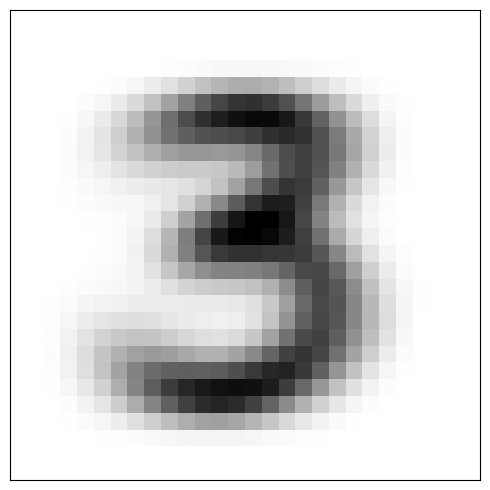

In [51]:
X_three_mean = np.mean(X_threes, axis=0, keepdims=True)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(X_three_mean.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

Run the following code to first create a new data matrix that centers the data by subtracting the mean image, and then visualise some of the images and compare to the original data. Note: you will need to replace `X_three_mean` with the name you gave the mean image in the computation above.

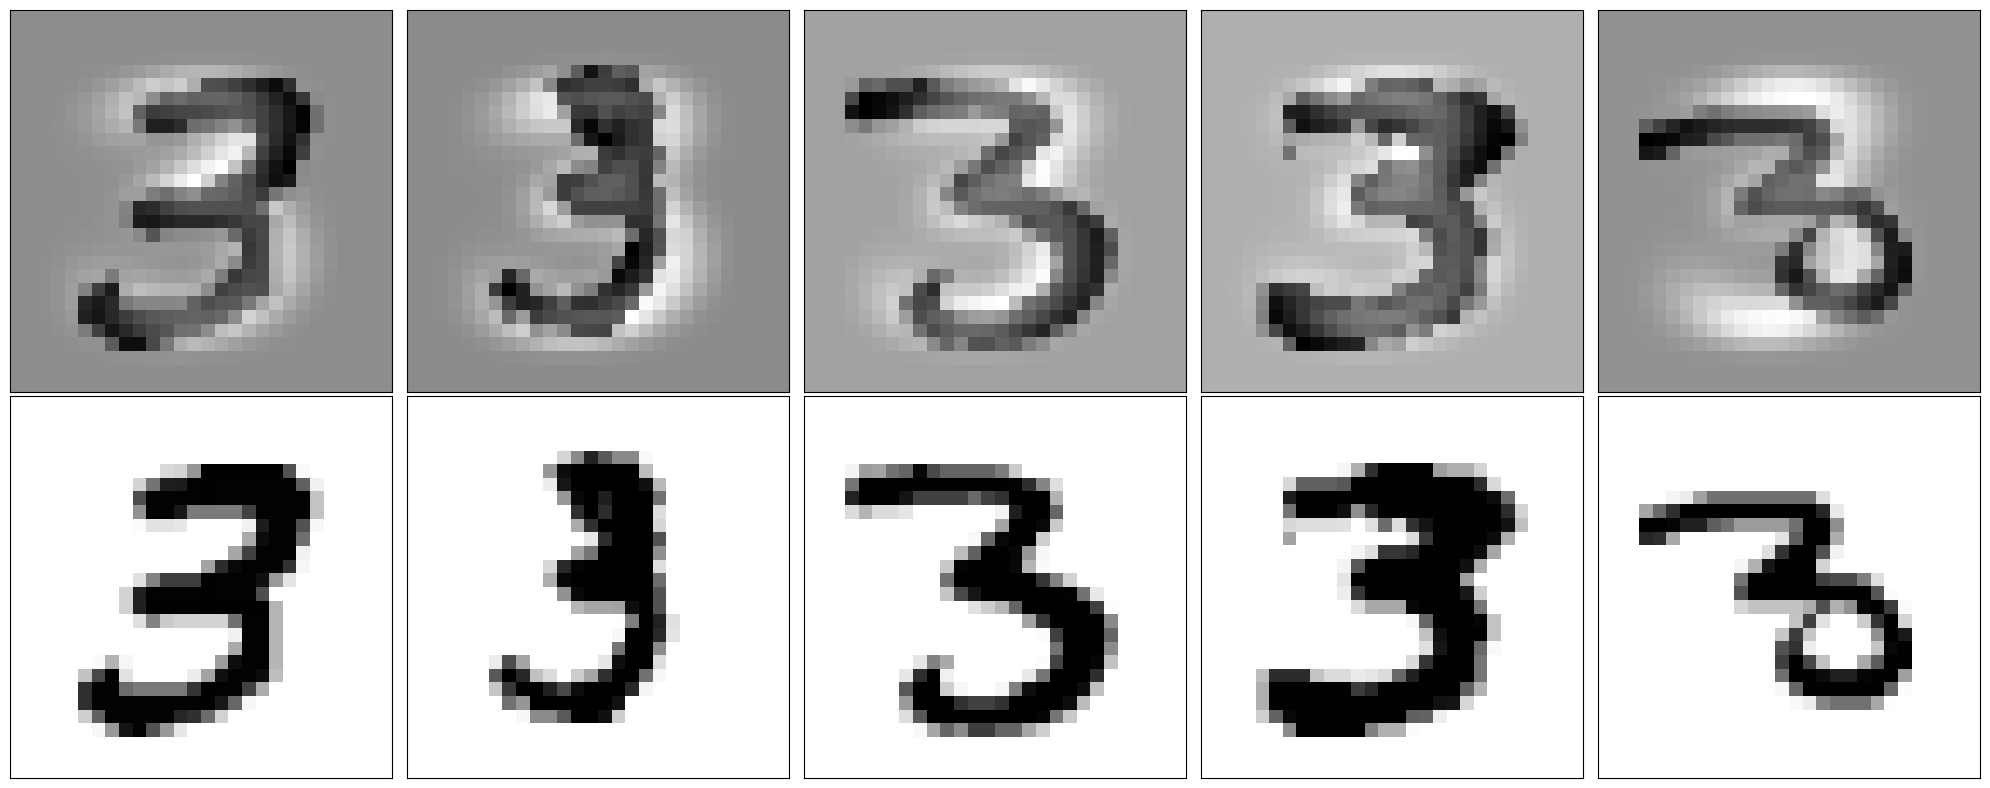

In [52]:
X_three_centred = X_threes - X_three_mean

n_images = 5

fig = plt.figure(figsize=(4*n_images, 4*2))
for j in range(n_images):
  ax = fig.add_subplot(2, n_images, j+1)
  ax.imshow(X_three_centred[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])

  ax = fig.add_subplot(2, n_images, j+1+n_images)
  ax.imshow(X_threes[j,:].reshape((28,28)), cmap='gray_r')
  ax.set_xticks([])
  ax.set_yticks([])
fig.tight_layout()

### 🚩 Exercise 5 (CORE)

Comment on whether or not the images need to be standardized before using PCA

We know from lectures, that if the features have very different scales, then the principal components can be dominated by the features with high variance. However, for imaging data, the pixels are measured in the same units. Thus, no scaling is required but the features do need to be centered. Ideed, there are some pixels (e.g. at the edges of the image) with very little variation, and we want them to have less influence on the principal components compared with the more important pixels towards the center; by not scaling the features, this is incorporated. 

🏁 **Now, is a good point to switch driver and navigator**

# PCA <a id='pca'></a>

Now, we will perform PCA to summarize the main patterns in the images. We will use the [`PCA()`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) transform from the `sklearn.decomposition` package:

- We can specify the number of components with the option `n_components`. If omitted, all components are kept.

- Note that by default the `PCA()` transform centers the variables to have zero mean (but does not scale them). After fitting, we can access the mean through the attribute `mean_`. If we also want to standardize to have not only zero mean but also unit variance, we can set `whiten=True`.

- We can access the basis vectors (principal components) through the `components_` attribute.

- We can call `fit()` to fit the model, followed by `transform` to obtain the low-dimensional representation (or also `fit_transform`). 

 First, let's create the PCA transform and call `fit()`:

In [53]:
pca_threes = PCA(n_components = 200)
pca_threes.fit(X_threes)


PCA(n_components=200)

## Examining the Basis Vectors and Scores <a id='basis'></a>

### 🚩 Exercise 6 (EXTRA)
 
Plot the mean image by accessing the `mean_` attribute and check that it is the same as above.

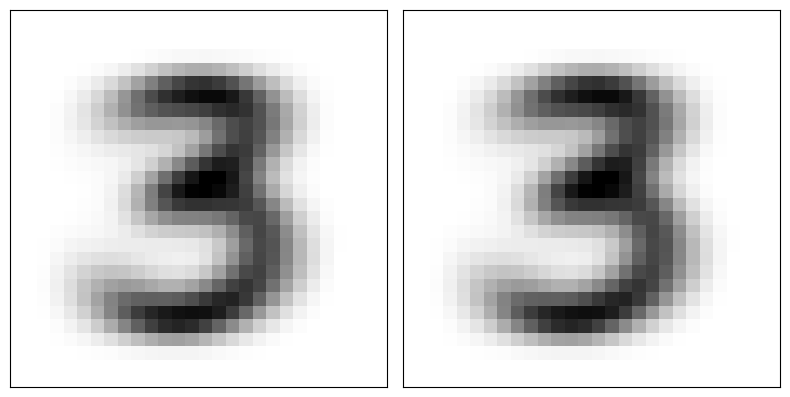

In [54]:
fig, ax = plt.subplots(1,2,figsize=(8,8))
ax[0].imshow(pca_threes.mean_.reshape(28, 28), cmap='gray_r')
ax[1].imshow(X_three_mean.reshape(28, 28), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 7 (CORE)

Plot the the first ten basis vectors as images by accessing the `components_` attribute. Overall, what patterns do they seem describe? 

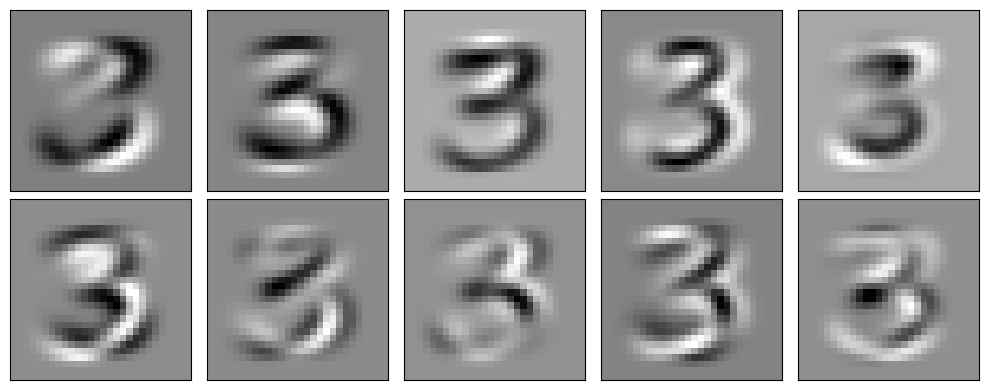

In [55]:
import math
n_plot = 10

fig, ax = plt.subplots(2,5,figsize=(10,4))
for n in range(n_plot):
  ax[math.floor(n/5), n - 5*math.floor(n/4)].imshow(pca_threes.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The basis vectors seem to mostly describe differences in orientation and style of the images. In general, it becomes more difficult to describe the patterns when we examine the latter basis vectors. We will look at later visualizations to better understand the patterns represented by each basis vector.

### 🚩 Exercise 8 (CORE)

a) Use the `transform()` method to compute the PCA scores and save them in an object called `scores`. Then, plot the data points in the low-dimensional space spanned by the first two principal components. 

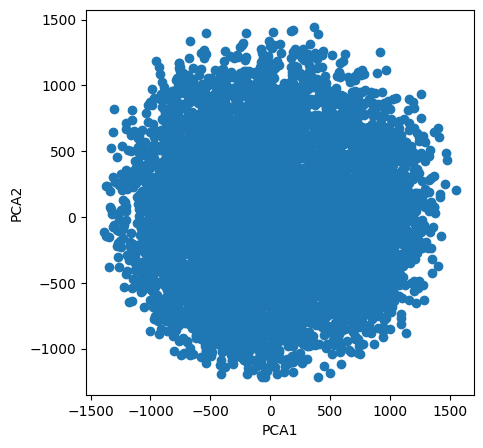

In [56]:
scores = pca_threes.transform(X_threes)

i, j = 0, 1 #component indicies 
fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.scatter(scores[:,i], scores[:,j])
ax.set_xlabel('PCA%d' % (i+1))
ax.set_ylabel('PCA%d' % (j+1))
plt.show()

To better interpret the latent dimensions, let's look at some projected points along each dimension and the corresponding images. Specifically, run the following code to:

- first compute the $5, 25, 50, 75, 95\%$ quantiles of the scores for the first two dimensions
- then find the data point whose projection is closest to each combination of quantiles.

In [57]:
s1q = np.quantile(scores[:,0],[.05,.25,.5,.75,.95])
s2q = np.quantile(scores[:,1],[.05,.25,.5,.75,.95])

idx = np.zeros([len(s1q),len(s2q)])

for i in range(len(s1q)):
    for j in range(len(s2q)):
        aux = ((scores[:,0] - s1q[i])**2 + (scores[:,1] - s2q[j])**2).reshape(N,1)
        idx[i,j] = np.where(aux == min(aux))[0][0]

idx = idx.astype(int)

b) Now, add these points in red to your plot above in.

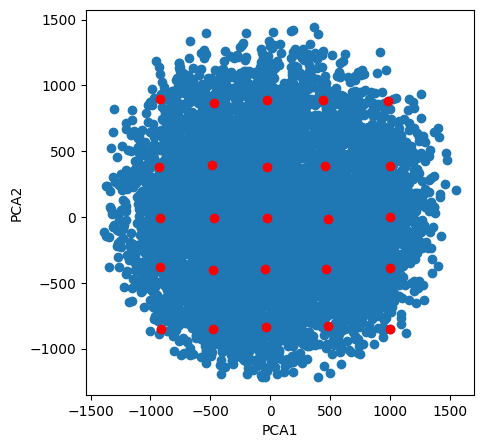

In [58]:
i, j = 0, 1 #component indicies 
fig, ax = plt.subplots(1,1,figsize=(5, 5))
ax.scatter(scores[:,i], scores[:,j])
ax.scatter(scores[idx.reshape(-1),i], scores[idx.reshape(-1),j],c = 'r')
ax.set_xlabel('PCA%d' % (i+1))
ax.set_ylabel('PCA%d' % (j+1))
plt.show()

c) Run the following code to plot the images corresponding to this grid of points. Describe the general pattern of the first (left to right) and second (down to up) principal component.

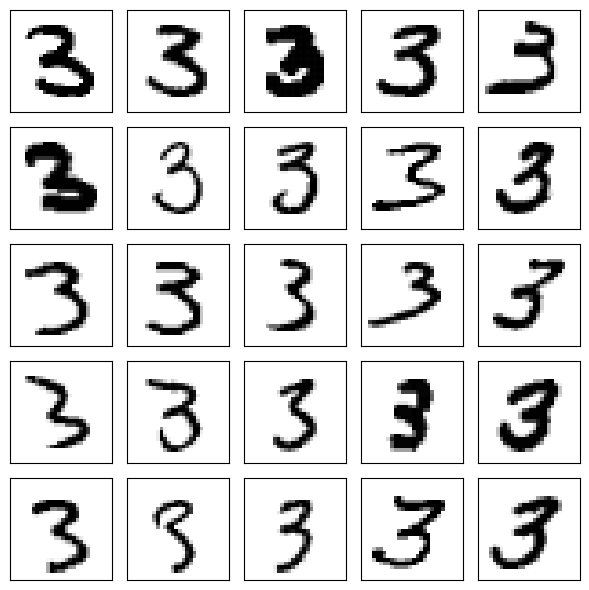

In [59]:
fig, ax = plt.subplots(len(s1q),len(s2q),figsize=(6,6))
for i in range(len(s1q)):
    for j in range(len(s2q)):
        ax[len(s2q)-1-j,i].imshow(X_threes[idx[i,j],:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

As we move from left to right along the first principal component, we see that its seems to capture the orientation of the digit. As we move up along the second principal component, we see that it seems to capture line thickness.

You can also try to create some artificial images, by fixing different values of the weights. This can also help to interpret the latent dimensions. 

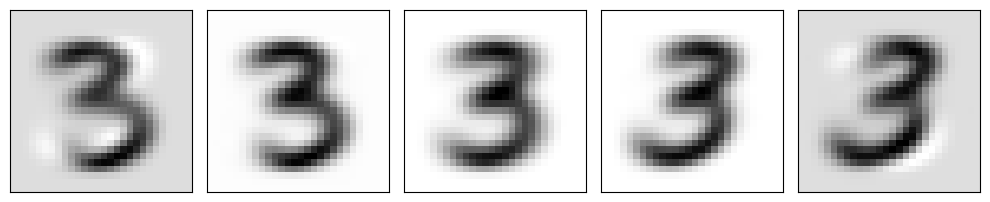

In [60]:
weight1 = [-1000,-500,0,500,1000]
weight2 = 0

images_pc1 = np.zeros([len(weight1),D])

count = 0
for w in weight1:   
    images_pc1[count,:] =(pca_threes.mean_ + pca_threes.components_[0,:]*w+pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight1),figsize=(10,6))
for i in range(len(weight1)):
    ax[i].imshow(images_pc1[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

### 🚩 Exercise 9 (CORE)

Repeat this to describe the third principal component. Look at the histogram of its scores to decide what values of weights to use. 

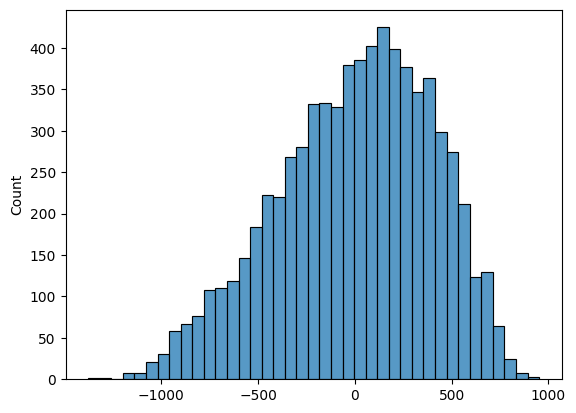

In [61]:
# First, look at distribution of the third principal component
import seaborn as sns

sns.histplot(scores[:,3])
plt.show()

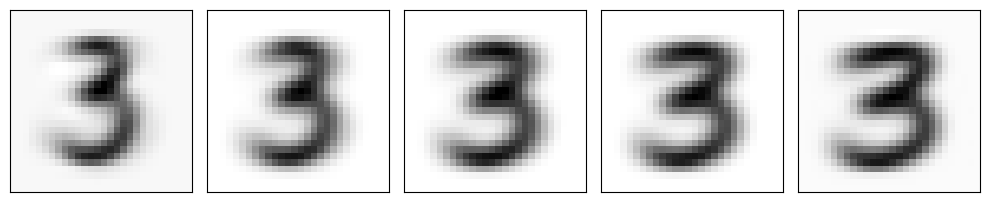

In [62]:
# Take weight values based on the distribution of the scores
weight3 = [-700,-300,0,300,700]
weight2 = 0
weight1 = 0

images_pc3 = np.zeros([len(weight3),D])

count = 0
for w in weight3:   
    images_pc3[count,:] =(pca_threes.mean_ + pca_threes.components_[2,:]*w + 
                          pca_threes.components_[0,:]*weight1 + pca_threes.components_[1,:]*weight2)
    count += 1
    

fig, ax = plt.subplots(1,len(weight3),figsize=(10,6))
for i in range(len(weight3)):
    ax[i].imshow(images_pc3[i,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The third principal component seems to describe the width of the images. 

### 🚩 Exercise 10 (EXTRA)

In lecture, we saw that we can also compute the basis vectors from an SVD decomposition of the data matrix. Use the `svd` function in `scipy.linalg` to compute the first three basis vectors and verify that they are the same (up to a change in sign -- note that the signs may be flipped because each principal component specifies a direction in the $D$-dimensional space and flipping the sign has no effect as the direction does not change). 

Does `PCA()` perform principal component analysis using an eigendecomposition of the empirical covariance matrix or using a SVD decomposition of the data matrix?

In [63]:
from scipy.linalg import svd
U, Dmat, V_T = svd(X_three_centred, full_matrices=True) 

print(U.shape, Dmat.shape, V_T.shape)

(7141, 7141) (784,) (784, 784)


Setting `full_matrices=False` would produce the "economy SVD" where only the first $D$ columns of the left singular vectors are returned. 

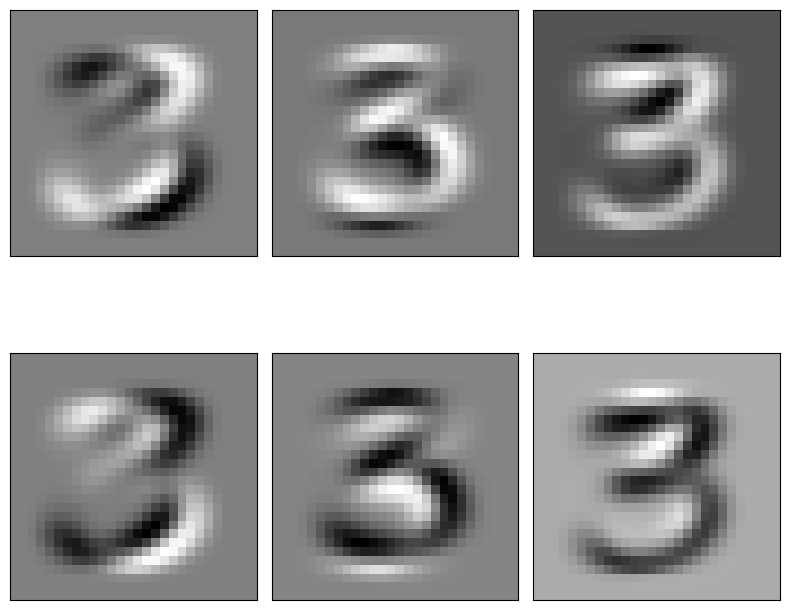

In [64]:
n_plot = 3

fig, ax = plt.subplots(2,3,figsize=(8, 8))
for n in range(n_plot):
  ax[0,n].imshow(V_T[n,:].reshape((28,28)), cmap='gray_r')
  ax[1,n].imshow(pca_threes.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Also, `PCA()` uses an SVD decompostion. Different SVD solvers are available and the default is selected based on the size of the data matrix and number of components. 

🏁 **Now, is a good point to switch driver and navigator**

## Selecting the Number of Components <a id='nocomponents'></a>

### 🚩 Exercise 11 (CORE)

Next, let's investigate how many components are needed by considering how much variance is explained by each component.

Note that the `pca_threes` object has an attribute `explained_variance_` (variance of each component) and `explained_variance_ratio_` (proportion of variance explained by each component). 

Plot both the proportion of variance explained and the cummulative proportion of variance explained. Provide a suggestion of how many components to use. How much variance is explained by the suggest number of components? Comment on why we may be able to use this number of components in relation to the total number of features.

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `cumsum()` to compute the cummulative sum of the elements in a vector.
</details>

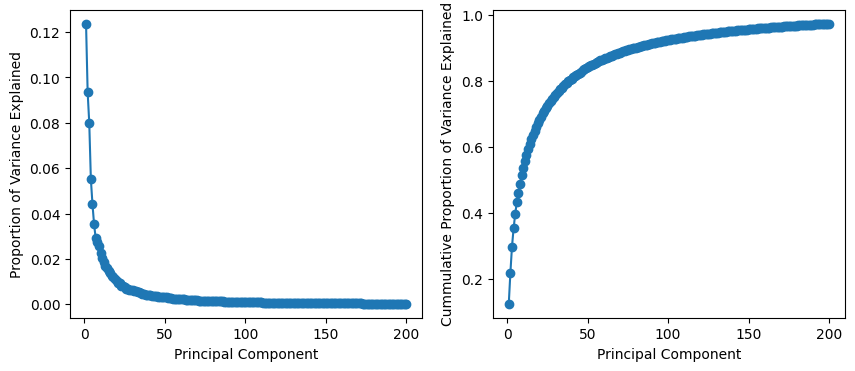

In [65]:
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(pca_threes.n_components_)+1
ax[0].plot(ticks, pca_threes.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, pca_threes.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

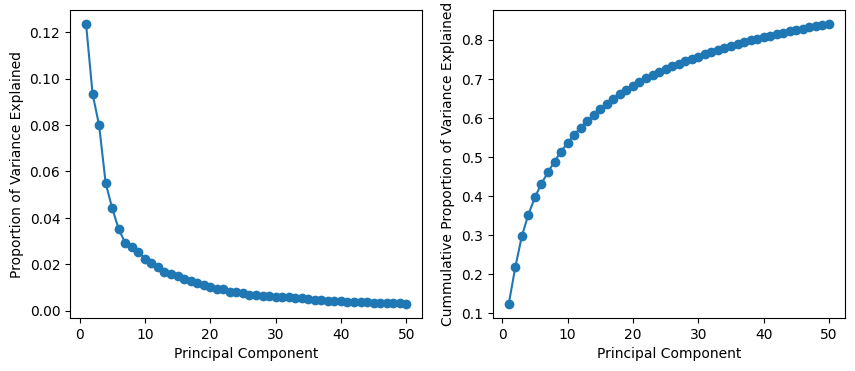

In [66]:
# Zoom in on the first 50
n_c_max = 50
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(n_c_max)+1
ax[0].plot(ticks, pca_threes.explained_variance_ratio_[range(n_c_max)], marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, pca_threes.explained_variance_ratio_[range(n_c_max)].cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

There appears to be an elbow around 7 components, after that the proportion of variance explained by each component drops off. If we use 7 components, we explain about $46\%$ of the variance. Because of the high correlation of the pixels, we can explain a large amount of the variance with $L<<D$ components.  

Note your answer can vary here and will very much depend on the problem at hand. If for example you are using PCA for feature engineering, you may be interested in a large number of components that together explain a specified amount of the variance (e.g. $80\%$).  

In [67]:
sum(pca_threes.explained_variance_ratio_[range(7)])

np.float64(0.4605188164917003)

### 🚩 Exercise 12 (CORE)

For your selected number of components, compute the reconstruted images. Plot the reconstruction for a few images and compare with the original images. Comment on the results.  

<br>
<details><summary><b><u>Hint</b></u></summary>

You can use `inverse_transform()` to decode the scores.
</details>

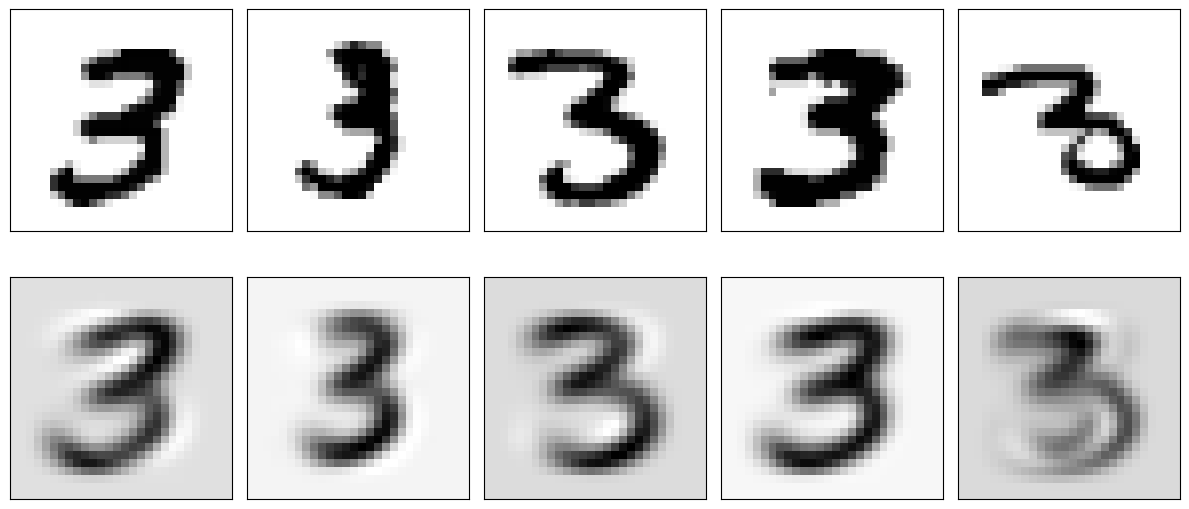

In [68]:
pca_threes_n7 = PCA(n_components = 7).fit(X_threes)
scores_n7 = pca_threes_n7.transform(X_threes)
X_r = pca_threes_n7.inverse_transform(scores_n7)

n_images = 5
fig, ax = plt.subplots(2,n_images,figsize=(12, 6))
for n in range(n_images):
  ax[0,n].imshow(X_threes[n,:].reshape((28,28)), cmap='gray_r')
  ax[1,n].imshow(X_r[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

With only 7 components, it is able to capture well the main characteristics of image. The reconstruction of some images is not as good, for example the last image, with a more unique style. 

🏁 **Now, is a good point to switch driver and navigator**

## Other Digits <a id='other'></a>

Now, let's consider another digit. 

### 🚩 Exercise 13 (CORE)

Perform PCA for another choice of digit. What do the first two components describe? Do some digits have better approximations than others? Comment on why this may be.

In [69]:
# Extract data and fit PCA
X_sevens = np.asarray(digits_dict['7'])
N, D = X_sevens.shape

pca_sevens = PCA(n_components = 50)
pca_sevens.fit(X_sevens)

PCA(n_components=50)

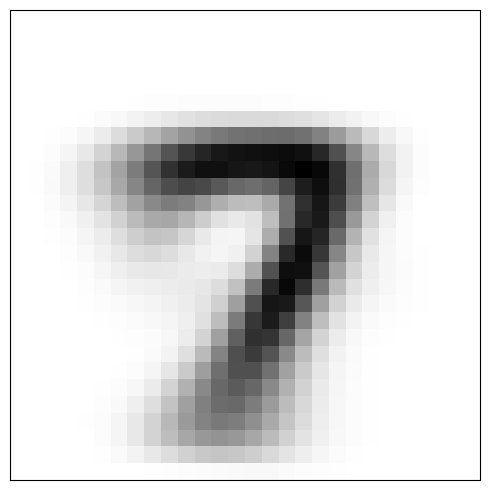

In [70]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_sevens.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

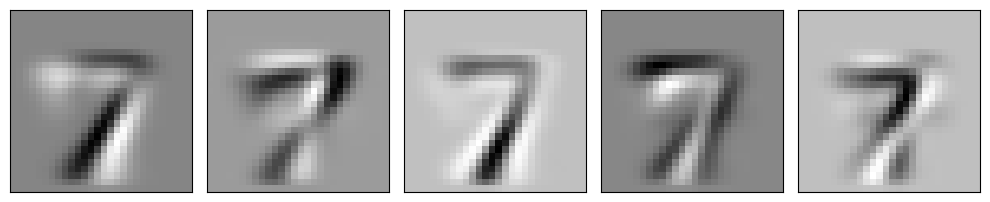

In [71]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_sevens.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

The first component seems to describe orientation, while the second seems to describe a different style.

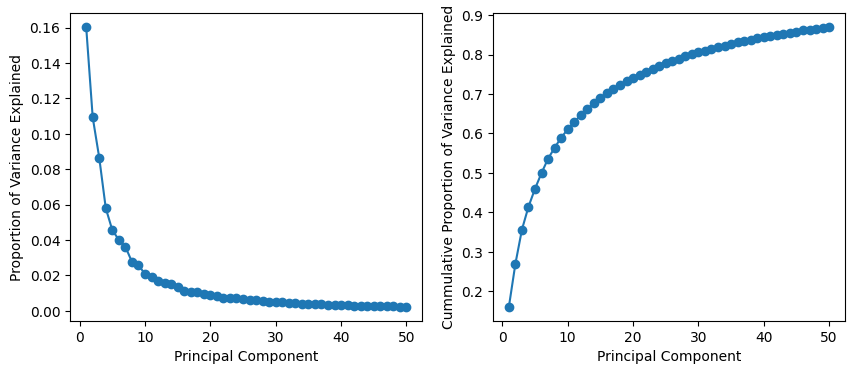

In [72]:
# Scree plot of PVE
fig, ax = plt.subplots(1,2, figsize = (10,4))
ticks = np.arange(pca_sevens.n_components_)+1
ax[0].plot(ticks, pca_sevens.explained_variance_ratio_, marker='o')
ax[0].set_xlabel('Principal Component')
ax[0].set_ylabel('Proportion of Variance Explained')
ax[1].plot(ticks, pca_sevens.explained_variance_ratio_.cumsum(), marker='o')
ax[1].set_xlabel('Principal Component')
ax[1].set_ylabel('Cummulative Proportion of Variance Explained')
plt.show()

In [73]:
print(sum(pca_sevens.explained_variance_ratio_[range(8)]))
print(sum(pca_sevens.explained_variance_ratio_[range(7)]))

0.5638239542554216
0.536146405512201


There seems to be an elbow around 8 (or 10) components, which explains approximately $56\%$ of the variance. The PVE seems to be slightly higher than for three. In general, we may anticipate less components for a digit in which we might expect less variation.

### Exercise 14 (EXTRA)

Finally, consider now two digits of your choice (edit the code below if you wish to pick different digits).


In [74]:
# Extract data 
X_twodigits = np.concatenate((digits_dict['3'], digits_dict['8']))
N, D = X_twodigits.shape

Run the following code to compute and plot the mean and some of the principle components for this dataset. 

In [75]:
# Fit PCA
pca_digits = PCA(n_components = 50)
pca_digits.fit(X_twodigits)

PCA(n_components=50)

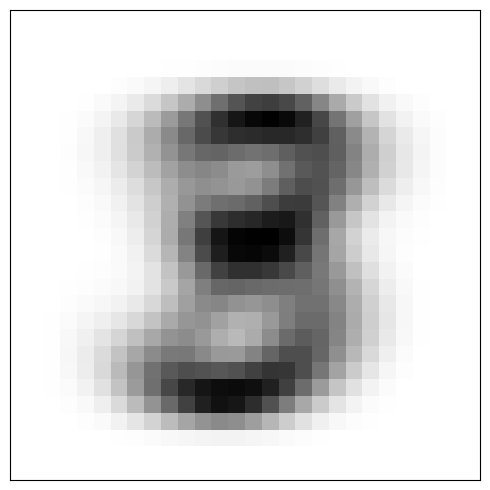

In [76]:
# Plot the mean image
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
ax.imshow(pca_digits.mean_.reshape(28, 28), cmap='gray_r')
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()

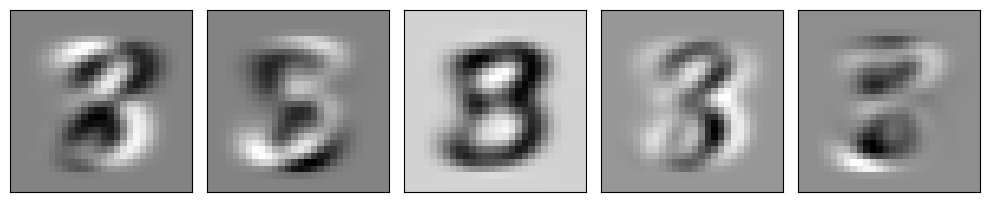

In [77]:
# Plot basis vectors
n_plot = 5
fig, ax = plt.subplots(1,5,figsize=(10,4))
for n in range(n_plot):
  ax[n].imshow(pca_digits.components_[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

Plot the projection of the data in the latent space and color the data by the labels. What do you observe?

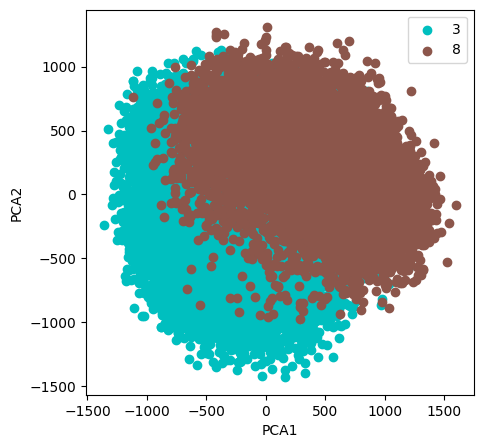

In [78]:
# Plot scores and color by label

scores = pca_digits.transform(X_twodigits)
y_twodigits = np.concatenate((3*np.ones((len(digits_dict['3']),1)), 8*np.ones((len(digits_dict['8']),1)))).reshape(-1)
yu =  [3,8]
colors = ['b','g','r','c','m','y','k','tab:orange','tab:brown','tab:pink']

i, j = 0, 1 #component indicies 
fig, ax = plt.subplots(1,1,figsize=(5, 5))
for dig in yu:
    ax.scatter(scores[y_twodigits==dig,i], scores[y_twodigits==dig,j], c = colors[dig],label=dig)
ax.legend()
ax.set_xlabel('PCA%d' % (i+1))
ax.set_ylabel('PCA%d' % (j+1))
plt.show()

Notice that the digits tend to cluster together. The 3s tend to have smaller values along PC 1 and PC 2, while the 8s have larger values. 

We can also generate artificial images and observe how image gradually change from 3s to 8s as move along the PCs. 

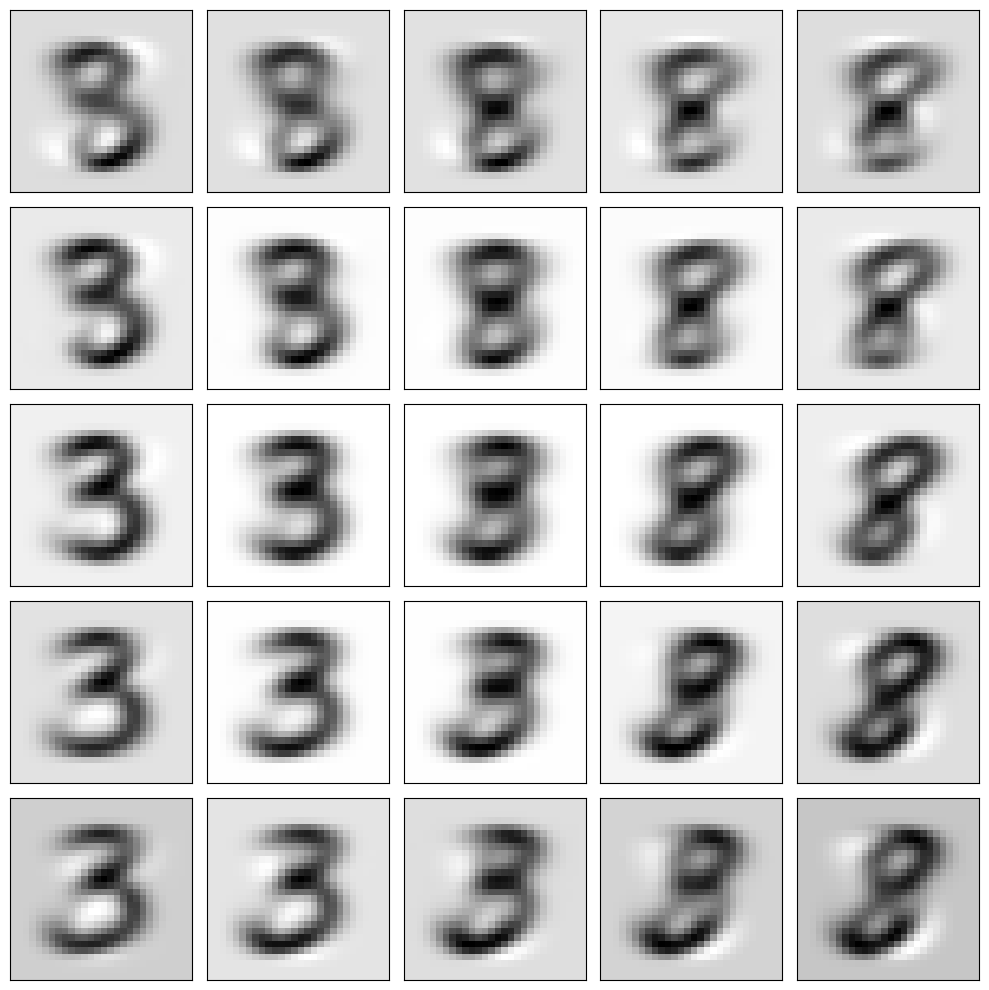

In [79]:
weight1 = [-800,-400,0,400,800]
weight2 = [-800,-400,0,400,800]

images_pc12 = np.zeros([len(weight1)*len(weight2),D])

count = 0
for w1 in weight1:
    for w2 in weight2:     
        images_pc12[count,:] =(pca_digits.mean_ + pca_digits.components_[0,:]*w1+pca_digits.components_[1,:]*w2)
        count += 1
    

fig, ax = plt.subplots(len(weight1),len(weight2),figsize=(10,10))
for i in range(len(weight1)):
    for j in range(len(weight2)):
        n = i * len(weight2) +  j
        ax[len(weight2)-1-j,i].imshow(images_pc12[n,:].reshape((28,28)), cmap='gray_r')
plt.setp(ax, xticks=[], yticks=[])
fig.tight_layout()

# Competing the Worksheet

At this point you have hopefully been able to complete all the CORE exercises and attempted the EXTRA ones. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Before generating the PDF, please go to Edit -> Edit Notebook Metadata and change 'Student 1' and 'Student 2' in the **name** attribute to include your name.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF.

In [80]:
!jupyter nbconvert --to pdf mlp_week02_key.ipynb 

[NbConvertApp] Converting notebook mlp_week02_key.ipynb to pdf
[NbConvertApp] ERROR | Error while converting 'mlp_week02_key.ipynb'
Traceback (most recent call last):
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/nbconvertapp.py", line 487, in export_single_notebook
    output, resources = self.exporter.from_filename(
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexporter.py", line 386, in from_filename
    return super().from_filename(filename, resources, **kw)  # type:ignore[return-value]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/exporter.py", line 201, in from_filename
    return self.from_file(f, resources=resources, **kw)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/codespace/.local/lib/python3.12/site-packages/nbconvert/exporters/templateexpo